In [18]:
# !pip install transformers

# import libraries
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import datetime
import random
import spacy
from torch.utils.data import TensorDataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data loading
We already created preprocessed data in the other python script SMM694_deeplearning.ipynb.
If the file `train_clean.csv` is available directly load and use here. If not, please run the following commented out blocks below to do the same preprocessing and generate the file.

In [9]:
folder = "" # "/content/drive/MyDrive/" for colab

#### Data Preprocessing

In [3]:
# # load the training data and split it into train and validation sets
# df_train = pd.read_csv("train.csv")
# df_test = pd.read_csv("test.csv")

In [ ]:
# # Data Preprocessing
# #-------------------
# # Tokenize the sentences
# nlp = spacy.load("en_core_web_sm")
# # preprocessing function
# def preprocessing_fn(df):
#     df["list_of_lemmatized_words"] = None
#     df["lemmatized_sentence"] = None
#     indexes_to_drop = []  # remembering indexes to drop empty reviews
#     list_of_lemmatized_words = []
#     lemmatized_sentences = []
#     for index, row in df.iterrows():   
#         # initial cleanup of the sentences
#         cleaned_text = " ".join(row["text"].replace("\n", "").replace("<s/>", "").replace("\"","").lower().split())
        
#         # Lemmatization
#         tmp_lms = []
#         str_lms = " "
#         for token in nlp(cleaned_text):
#             # remove stop words, punctuations and numbers
#             if not token.is_stop and not token.is_punct and not token.like_num:
#                 # list of lemmatized words
#                 tmp_lms.append(token.lemma_)
#                 # string of lemmatized words
#                 str_lms += token.lemma_ + " "
#         list_of_lemmatized_words.append(tmp_lms)
#         lemmatized_sentences.append(str_lms)

#         # Only keep non empty reviews
#         if len(tmp_lms) == 0:
#             indexes_to_drop.append(index)

#     df["list_of_lemmatized_words"] = list_of_lemmatized_words
#     df["lemmatized_sentence"] = lemmatized_sentences

#     # dropping reviews that have only stopwords, punctuations and numbers
#     df_clean = df.drop(index=indexes_to_drop)
#     return df_clean

# df_clean_train = preprocessing_fn(df_train)


In [10]:
# # save df to csv
# df_clean_train.to_csv(os.path.join(folder,'train_clean.csv'), index=False, header=True)

#### Load preprocessed data

In [11]:
torch.cuda.empty_cache()

# load df from csv
df_clean_train = pd.read_csv(os.path.join(folder,"train_clean.csv"))  # change path accordingly

# Data splits
# -------------
# split the data into train, validation and test sets
seed1 = 42
seed2 = 52
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(df_clean_train.drop('label', axis=1), df_clean_train['label'], test_size=0.2, random_state=seed1)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=X_test.shape[0], random_state=seed2)

X_train_and_val_nn = X_train_and_val['text']
X_train_nn = X_train['text']
X_val_nn = X_val['text']
X_test_nn = X_test['text']

### BERT Model - with Fixed Padding

In [15]:
# Load the BERT tokenizer and classifier
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Place the model on the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [16]:
# encode the data
train_encodings = tokenizer(list(X_train_nn), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(list(X_val_nn), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(X_test_nn), truncation=True, padding=True, max_length=128, return_tensors='pt')

In [19]:
# Convert to Dataset objects
train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(list(y_train)))
val_dataset = TensorDataset(val_encodings.input_ids, val_encodings.attention_mask, torch.tensor(list(y_val)))
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask, torch.tensor(list(y_test)))

In [20]:
# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Train the classification model
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 2  # Running on only 2 epochs to prevent overfitting

for epoch in tqdm(range(epochs)):
    model.train()
    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

In [ ]:
# Save the model
model.save_pretrained('./model/')

This saved model can be found [here](https://drive.google.com/drive/folders/1MTNAF2_mTBiGG4TdGKqYe6Oa4EWd48hg?usp=sharing)

In [25]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert_fixed_padding/')   # change the path here
model.to(device)
# Evaluate on the test dataset
model.eval()
test_loss = 0
predictions, true_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        test_loss += outputs.loss.item()

        _, predicted = torch.max(outputs.logits, 1)

        # Collect predictions and true labels for F1 score calculation
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate F1 score
f1 = f1_score(true_labels, predictions, average='macro')
print(f'F1 Score: {f1:.4f}')

100%|██████████| 132/132 [00:25<00:00,  5.24it/s]

F1 Score: 0.6032


### BERT Model (Optimized) - with Smart Padding
In order to improve over the previous model in terms of computatioal efficiency, smart padding technique is used where the padding is dynamically changed based on the length of the sequences.

In [ ]:
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [5]:
tokens = []
labels = []
max_len = 256
update_interval = 1000

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(X_train_nn)))

# For each training example...
for text in tqdm(X_train_nn):
    # Report progress.
    if ((len(tokens) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(tokens)))
    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_len,
                                 truncation=True,
                                 padding=False)
    # Add the tokenized result to our list.
    tokens.append(input_ids)

print('DONE with {} samples'.format(len(tokens)))


Tokenizing 12,626 training samples...


  0%|          | 32/12626 [00:00<00:39, 317.00it/s]

  Tokenized 0 samples.


  8%|▊         | 1025/12626 [00:05<01:03, 182.82it/s]

  Tokenized 1,000 samples.


 16%|█▌        | 2023/12626 [00:14<01:07, 156.53it/s]

  Tokenized 2,000 samples.


 24%|██▍       | 3035/12626 [00:19<00:58, 164.90it/s]

  Tokenized 3,000 samples.


 32%|███▏      | 4008/12626 [00:29<01:17, 110.57it/s]

  Tokenized 4,000 samples.


 40%|████      | 5063/12626 [00:36<00:20, 366.92it/s]

  Tokenized 5,000 samples.


 48%|████▊     | 6056/12626 [00:38<00:15, 419.65it/s]

  Tokenized 6,000 samples.


 56%|█████▌    | 7029/12626 [00:41<00:25, 223.63it/s]

  Tokenized 7,000 samples.


 64%|██████▎   | 8021/12626 [00:47<00:27, 167.52it/s]

  Tokenized 8,000 samples.


 72%|███████▏  | 9045/12626 [00:51<00:08, 404.65it/s]

  Tokenized 9,000 samples.


 80%|███████▉  | 10054/12626 [00:54<00:07, 362.70it/s]

  Tokenized 10,000 samples.


 88%|████████▊ | 11086/12626 [00:57<00:03, 413.28it/s]

  Tokenized 11,000 samples.


 95%|█████████▌| 12018/12626 [01:00<00:03, 200.15it/s]

  Tokenized 12,000 samples.


100%|██████████| 12626/12626 [01:03<00:00, 198.12it/s]

DONE with 12626 samples


In [6]:
# Sort training samples by the length of their input sequence.
train_samples = sorted(zip(tokens, y_train), key=lambda x: len(x[0]))
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 256


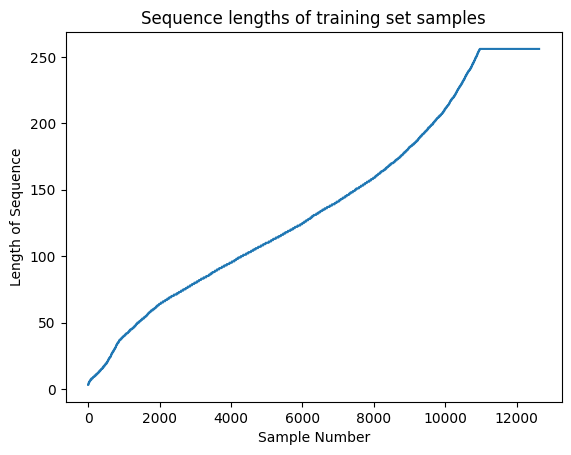

In [7]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

# Plot the sequence lengths for visualization.
plt.plot(range(0, len(sorted_lengths)), sorted_lengths)
plt.xlabel('Sample Number')
plt.ylabel('Length of Sequence')
plt.title('Sequence lengths of training set samples')
plt.show()

In [8]:
def create_smart_padded_batches(text_samples, labels, batch_size, max_len = 256):
    print('Forming smart batches from {} examples. Batch size {}\n'.format(len(text_samples), batch_size))
    # ------------------------------------------------------------------
    # First tokenize all the samples and truncate them to a max length.
    # ------------------------------------------------------------------
    tokenized_inputs = []
    for sample in tqdm(text_samples):
        # Tokenize the sample
        tokenized_input = tokenizer.encode(text=sample,
                                     add_special_tokens=True,
                                     max_length=max_len,
                                     truncation=True,
                                     padding=False)
        # Add to list
        tokenized_inputs.append(tokenized_input)
    print('Finished tokenizing: {:>10,} samples\n'.format(len(tokenized_inputs)))

    # ---------------------------------------------------------------------
    # Batch the tokenized sequences together after sorting them by length.
    # ---------------------------------------------------------------------
    sorted_samples_labels = sorted(zip(tokenized_inputs, labels), key=lambda x: len(x[0]))

    # Create lists of batches of samples and labels.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    # Loop over the input samples until it is empty
    while len(sorted_samples_labels) > 0:
        # Print progress after 500 batches.
        if ((len(batch_ordered_sentences) % 500) == 0):
            print(' Finished {:,} batches.'.format(len(batch_ordered_sentences)))

        # num_samples_to_pick = normally batch size, for the last batch it will be the remaining samples
        num_samples_to_pick = min(batch_size, len(sorted_samples_labels))

        # Start at a random point in the list of samples and choose num_samples_to_pick contiguous samples
        start = random.randint(0, len(sorted_samples_labels) - num_samples_to_pick)
        batch = sorted_samples_labels[start:start + num_samples_to_pick]

        # Split the (samples, labels) tuples into samples and labels
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the original list of training samples.
        del sorted_samples_labels[start:start + num_samples_to_pick]
    print('\n  Finished processing {:,} batches.'.format(len(batch_ordered_sentences)))

    # --------------
    #  Add Padding
    # --------------
    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):
        # Lists of padded inputs and masks
        batch_padded_inputs = []
        batch_attn_masks = []

        # Get the longest sequence size in the current batch
        max_size = max([len(sen) for sen in batch_inputs])

        # Pad the sequences uptp the max_size and also create the attention masks.
        for sen in batch_inputs:
            padding_count = max_size - len(sen)
            # Add the token for padding at the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*padding_count
            # Create the attention mask with 1 for real tokens and 0 for padding tokens.
            attn_mask = [1] * len(sen) + [0] * padding_count
            # Add these to the lists.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Convert to tensors and add to the lists.
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('Finished Padding.')
    token_count_padded = 0
    for batch in py_inputs:
        for sen in batch:
            token_count_padded += len(sen)
    token_count_fixed = max_len * len(py_inputs) * batch_size
    print('  Number of tokens with fixed padding: {}'.format(token_count_fixed))
    print('  Number of tokens with smart padding: {}'.format(token_count_padded))
    print('  Percentage reduction in tokes is: {:,.2f}%'.format(100*(token_count_fixed-token_count_padded)/token_count_fixed))

    # Return the dataset
    return (py_inputs, py_attn_masks, py_labels)

In [9]:
def format_time(elapsed):
    # Return time as string hh:mm:ss
    time_int = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=time_int))

In [10]:
# Create config and network for multiclass sequence classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',
                                    num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path='bert-base-uncased',
    config=config)

print('Config:', str(type(config)), '\n')
print('Model type:', str(type(model)))

# Load the model on the GPU
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

desc = model.to(device)
print('DONE.')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Config: <class 'transformers.models.bert.configuration_bert.BertConfig'> 

Model type: <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>
DONE.


In [11]:
# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-6, eps = 1e-8)

batch_size = 16
epochs = 4

# Max length for tokenization
max_len = 256

# Perform tokenization and smart batching on the training data
(py_inputs, py_attn_masks, py_labels) = create_smart_padded_batches(X_train_nn, y_train, batch_size, max_len)
total_steps = len(py_inputs) * epochs   # training_steps = [number of batches] x [number of epochs].

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Forming smart batches from 12626 examples. Batch size 16



100%|██████████| 12626/12626 [00:39<00:00, 322.92it/s]


Finished tokenizing:     12,626 samples

 Finished 0 batches.
 Finished 500 batches.

  Finished processing 790 batches.
Finished Padding.
  Number of tokens with fixed padding: 3235840
  Number of tokens with smart padding: 1765070
  Percentage reduction in tokes is: 45.45%


In [12]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# Set the seed value all over the place to make this reproducible.
seed_val = 87
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in tqdm(range(0, epochs)):
    # ========================================
    #               Training
    # ========================================
    print('\n=== Epoch {:} / {:} ==='.format(epoch_i + 1, epochs))

    # Randomnize the training set, i.e smart batch again
    if epoch_i > 0:
        (py_inputs, py_attn_masks, py_labels) = create_smart_padded_batches(X_train_nn, y_train, batch_size, max_len)
    print('Training on {:} batches...'.format(len(py_inputs)))

    start_time = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step in tqdm(range(0, len(py_inputs))):
        # Copy the current training batch to the GPU.
        batch_input_ids = py_inputs[step].to(device)
        batch_input_mask = py_attn_masks[step].to(device)
        batch_labels = py_labels[step].to(device)

        # Clear gradients
        model.zero_grad()
        # Forward pass
        result = model(
            batch_input_ids,
            token_type_ids=None,
            attention_mask=batch_input_mask,
            labels=batch_labels)

        # Compute training loss and accumulate
        loss = result.loss
        total_train_loss += loss.item()
        # Backward pass
        loss.backward()

        # To prevent exploding gradinets problem, clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update the parameters and the learning rate.
        optimizer.step()
        scheduler.step()
    # Calculate the average training loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - start_time)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    print("\nRunning Validation...")
    (py_val_inputs, py_val_attn_masks, py_val_labels) = create_smart_padded_batches(X_val_nn, y_val, batch_size, max_len)

    # Tracking variables
    predictions , true_labels = [], []

    # model.eval()
    total_val_loss = 0
    # For each batch of validation
    for step in range(0, len(py_val_inputs)):
        # Copy the batch to the GPU.
        batch_input_ids_val = py_val_inputs[step].to(device)
        batch_input_mask_val = py_val_attn_masks[step].to(device)
        batch_labels_val = py_val_labels[step].to(device)

        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(batch_input_ids_val, token_type_ids=None,
                            attention_mask=batch_input_mask_val, labels=batch_labels_val)
        total_val_loss += outputs.loss
        logits = outputs.logits
        # compute validation loss

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels_val.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Combine the results across the batches.
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    # Choose the label with the highest score as our prediction.
    preds = np.argmax(predictions, axis=1).flatten()

    f1 = f1_score(true_labels, preds, average='macro')
    # Calculate the average val loss over all of the batches.
    avg_val_loss = total_val_loss / len(py_val_inputs)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
            'validation loss': avg_val_loss,
            'validation F1 score': f1
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  0%|          | 0/4 [00:00<?, ?it/s]


=== Epoch 1 / 4 ===
Training on 790 batches...


100%|██████████| 790/790 [05:22<00:00,  2.45it/s]



  Average training loss: 1.00
  Training epcoh took: 0:05:22

Running Validation...
Forming smart batches from 4209 examples. Batch size 16



100%|██████████| 4209/4209 [00:12<00:00, 339.86it/s]


Finished tokenizing:      4,209 samples

 Finished 0 batches.

  Finished processing 264 batches.
Finished Padding.
  Number of tokens with fixed padding: 1081344
  Number of tokens with smart padding: 597971
  Percentage reduction in tokes is: 44.70%


 25%|██▌       | 1/4 [06:11<18:35, 371.67s/it]


=== Epoch 2 / 4 ===
Forming smart batches from 12626 examples. Batch size 16



100%|██████████| 12626/12626 [00:40<00:00, 308.00it/s]


Finished tokenizing:     12,626 samples

 Finished 0 batches.
 Finished 500 batches.

  Finished processing 790 batches.
Finished Padding.
  Number of tokens with fixed padding: 3235840
  Number of tokens with smart padding: 1763766
  Percentage reduction in tokes is: 45.49%
Training on 790 batches...


100%|██████████| 790/790 [05:22<00:00,  2.45it/s]



  Average training loss: 0.85
  Training epcoh took: 0:05:23

Running Validation...
Forming smart batches from 4209 examples. Batch size 16



100%|██████████| 4209/4209 [00:13<00:00, 308.73it/s]


Finished tokenizing:      4,209 samples

 Finished 0 batches.

  Finished processing 264 batches.
Finished Padding.
  Number of tokens with fixed padding: 1081344
  Number of tokens with smart padding: 599920
  Percentage reduction in tokes is: 44.52%


 50%|█████     | 2/4 [13:07<13:14, 397.39s/it]


=== Epoch 3 / 4 ===
Forming smart batches from 12626 examples. Batch size 16



100%|██████████| 12626/12626 [00:38<00:00, 327.87it/s]


Finished tokenizing:     12,626 samples

 Finished 0 batches.
 Finished 500 batches.

  Finished processing 790 batches.
Finished Padding.
  Number of tokens with fixed padding: 3235840
  Number of tokens with smart padding: 1765078
  Percentage reduction in tokes is: 45.45%
Training on 790 batches...


100%|██████████| 790/790 [05:22<00:00,  2.45it/s]



  Average training loss: 0.81
  Training epcoh took: 0:05:22

Running Validation...
Forming smart batches from 4209 examples. Batch size 16



100%|██████████| 4209/4209 [00:13<00:00, 307.53it/s]


Finished tokenizing:      4,209 samples

 Finished 0 batches.

  Finished processing 264 batches.
Finished Padding.
  Number of tokens with fixed padding: 1081344
  Number of tokens with smart padding: 598322
  Percentage reduction in tokes is: 44.67%


 75%|███████▌  | 3/4 [19:59<06:44, 404.08s/it]


=== Epoch 4 / 4 ===
Forming smart batches from 12626 examples. Batch size 16



100%|██████████| 12626/12626 [00:40<00:00, 311.88it/s]


Finished tokenizing:     12,626 samples

 Finished 0 batches.
 Finished 500 batches.

  Finished processing 790 batches.
Finished Padding.
  Number of tokens with fixed padding: 3235840
  Number of tokens with smart padding: 1765392
  Percentage reduction in tokes is: 45.44%
Training on 790 batches...


100%|██████████| 790/790 [05:22<00:00,  2.45it/s]



  Average training loss: 0.78
  Training epcoh took: 0:05:22

Running Validation...
Forming smart batches from 4209 examples. Batch size 16



100%|██████████| 4209/4209 [00:13<00:00, 309.42it/s]


Finished tokenizing:      4,209 samples

 Finished 0 batches.

  Finished processing 264 batches.
Finished Padding.
  Number of tokens with fixed padding: 1081344
  Number of tokens with smart padding: 597226
  Percentage reduction in tokes is: 44.77%


100%|██████████| 4/4 [26:53<00:00, 403.27s/it]


Training complete!
Total training took 0:26:53 (h:mm:ss)


In [14]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.9986658079714714,
  'Training Time': '0:05:22',
  'validation loss': tensor(0.8971, device='cuda:0'),
  'validation F1 score': 0.554759488504652},
 {'epoch': 2,
  'Training Loss': 0.8475581101601637,
  'Training Time': '0:05:23',
  'validation loss': tensor(0.8506, device='cuda:0'),
  'validation F1 score': 0.5884499339827506},
 {'epoch': 3,
  'Training Loss': 0.8062762778771074,
  'Training Time': '0:05:22',
  'validation loss': tensor(0.8294, device='cuda:0'),
  'validation F1 score': 0.6060329085810211},
 {'epoch': 4,
  'Training Loss': 0.7810257289983049,
  'Training Time': '0:05:22',
  'validation loss': tensor(0.8322, device='cuda:0'),
  'validation F1 score': 0.606387278088957}]

By checking the validation loss, we stop the training here to avoid overfitting.

In [15]:
# Evaluate on the test split
(py_test_inputs, py_test_attn_masks, py_test_labels) = create_smart_padded_batches(X_test_nn, y_test, batch_size)

Forming smart batches from 4209 examples. Batch size 16



100%|██████████| 4209/4209 [00:24<00:00, 172.05it/s]


Finished tokenizing:      4,209 samples

 Finished 0 batches.

  Finished processing 264 batches.
Finished Padding.
  Number of tokens with fixed padding: 1081344
  Number of tokens with smart padding: 604755
  Percentage reduction in tokes is: 44.07%


In [16]:
# Prediction on test set with the best model
print('Predicting labels for {:,} test sentences...'.format(len(py_test_labels)))
model.eval()
predictions , true_labels = [], []

# For each batch of test
for step in range(0, len(py_test_inputs)):
    # Copy the batch to the GPU.
    b_input_ids = py_test_inputs[step].to(device)
    b_input_mask = py_test_attn_masks[step].to(device)
    b_labels = py_test_labels[step].to(device)

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Choose the label with the highest score as our prediction.
preds = np.argmax(predictions, axis=1).flatten()

# Calculate simple flat accuracy -- number correct over total number.
accuracy = (preds == true_labels).mean()

print('Accuracy: {:.3f}'.format(accuracy))
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, preds, average='macro')
print('F1 score: {:.3f}'.format(f1))

Predicting labels for 264 test sentences...
    DONE.
Accuracy: 0.617
F1 score: 0.613


#### Saving the best model

In [17]:
# Save the model and tokenizer - This is the best model
output_dir = "saved_model/"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved to:", output_dir)

Model and tokenizer saved to: saved_model/


The best model is also available for downloading from [here](https://drive.google.com/drive/folders/1n--UhRrl_ZvLUfJssD7LUSywOlC_aw_c)

In [18]:
# After saving the file in Colab, you can use the following code to download it to your local machine:
from google.colab import files

# Zip the saved_model directory to create a single zip file
!zip -r saved_model.zip saved_model

# Download the zip file to your local machine
files.download("saved_model.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/special_tokens_map.json (deflated 42%)
  adding: saved_model/tokenizer_config.json (deflated 45%)
  adding: saved_model/config.json (deflated 51%)
  adding: saved_model/vocab.txt (deflated 53%)
  adding: saved_model/pytorch_model.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Final prediction
Get the submission file

In [27]:
sub = pd.read_csv("/content/drive/MyDrive/submission.csv")

In [28]:
sub

,_id,pred_label
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
...,...,...
8938,8938,NaN
8939,8939,NaN
8940,8940,NaN
8941,8941,NaN


In [16]:
# Load the model and tokenizer from the saved directory
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/saved_model/")

In [30]:
# Use the test file provided to make predictions
df_test = pd.read_csv("/content/drive/MyDrive/test.csv")

In [31]:
df_test

,_id,text
0,0,"12oz bottle. label states ""produced on 04/08""\..."
1,1,This is one of my first Guezes and I am amazed...
2,2,Poured into my Hulk pint.\n\nQuick pour yields...
3,3,"Served in a Dogfish head goblet, check my twit..."
4,4,Hazy brass colour. Smells hoppy; floral and ci...
...,...,...
8938,8938,bomber into a hennepin glass\npoured aggressiv...
8939,8939,Had this on tap on a few different occasions a...
8940,8940,This was a great find. The ale poured a hazy b...
8941,8941,Pored into a nice pilsner glass and formed a d...


In [32]:
from torch.utils.data import TensorDataset, DataLoader
max_len = 256 # put that we chose during training
# tokenize the reviews
test_encodings = tokenizer(list(df_test['text']), truncation=True, padding=True, max_length=max_len, return_tensors='pt', add_special_tokens=True)
print('Finished tokenizing: {:>10,} samples\n'.format(len(test_encodings)))

# create dataset loaders for ease of use
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask)
test_loader = DataLoader(test_dataset, batch_size=16)

Finished tokenizing:          3 samples



In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the same device as input tensors

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [34]:
# evaluate
model.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        # get a batch
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        # predict
        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=None)
        logits = outputs.logits
        # store logits
        predictions.append(logits.cpu())


100%|██████████| 559/559 [01:58<00:00,  4.72it/s]


In [35]:
# concatenate results from all batches
predictions = np.concatenate(predictions, axis=0)
# predictions are argmax of logits
preds = np.argmax(predictions, axis=1).flatten()

In [36]:
preds

array([0, 0, 0, ..., 1, 0, 2])

In [37]:
# add predictions to submission file
sub['pred_label'] = preds

In [38]:
sub

,_id,pred_label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
8938,8938,2
8939,8939,2
8940,8940,1
8941,8941,0


In [41]:
# Save the predictions to the csv file
sub.to_csv("/content/drive/MyDrive/Colab Notebooks/submission.csv", index = False)